In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll  
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd

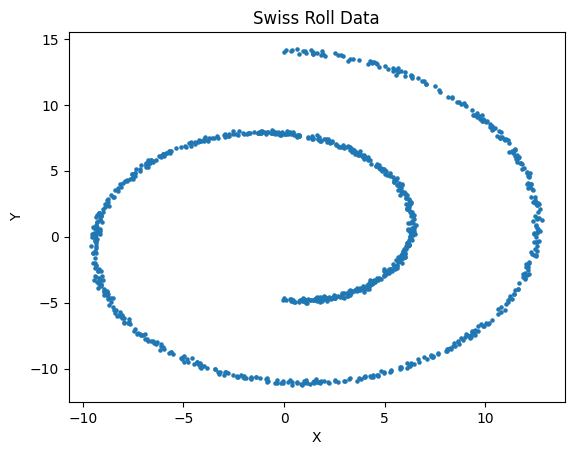

In [79]:
# Swiss Roll
data, _ = make_swiss_roll(1000, noise = 0.1)
data = data[:, [0, 2]]  

# plot
plt.scatter(data[:, 0], data[:, 1], s=5)
plt.title("Swiss Roll Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [80]:
# T 
T = 1000
# betas
betas = torch.linspace(1e-4, 0.02, T)
# alpha
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [81]:
def forward_process(x_0, t):

    alphas_bar_sqrt_t = alphas_bar_sqrt[t]
    alphas_bar_sqrt_t2= one_minus_alphas_bar_sqrt[t]
    noise = torch.randn_like(x_0)
    x_t = alphas_bar_sqrt_t * x_0 + alphas_bar_sqrt_t2 * noise
    return x_t, noise


In [82]:
class Net(nn.Module):
    def __init__(self, n_steps):
        super(Net, self).__init__()
 
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, 128),
                nn.Embedding(n_steps, 128),
                nn.Embedding(n_steps, 128),
            ]
        )
 
    def forward(self, x, t):
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)
        x = self.linears[-1](x)
 
        return x


In [1]:
model = Net(T)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
losses = [] 
dataloader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)
for epoch in range(4100):
    epoch_loss = 0
    for _, batch_x in enumerate(dataloader):
        batch_x = batch_x.float()
        batch_size = batch_x.shape[0]
        t = torch.randint(0, T, (batch_size // 2,))
        t = torch.cat([t, T - 1 - t], dim=0)
        t = t.unsqueeze(-1)
        x_t, noise = forward_process(batch_x, t)
        predict_noise = model(x_t, t.squeeze(-1))
        loss = criterion(predict_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    if (epoch % 100 == 0):
        print(loss)
        torch.save(model.state_dict(), 'model4_{}.pth'.format(epoch))

In [96]:
import json
with open('losses.json', 'w') as f:
    json.dump(losses, f) 

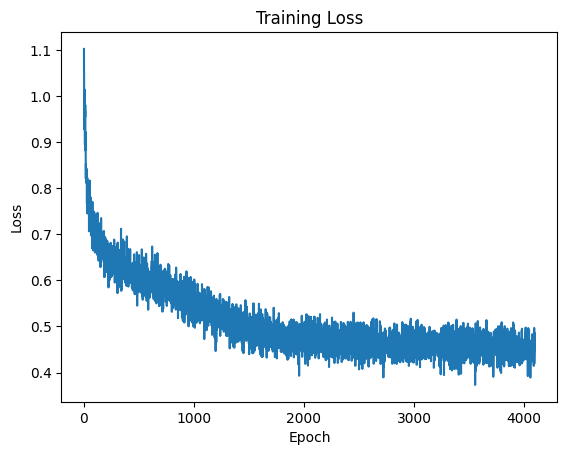

In [97]:

with open('losses.json', 'r') as f:
    losses = json.load(f)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [86]:
def reverse(model, x_t , t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    p_noise = model(x_t, t)
    mean = (1 / (1 - betas[t]).sqrt()) * (x_t - (betas[t] / one_minus_alphas_bar_sqrt[t] * p_noise))
    z = torch.randn_like(x_t)
    sigma_t = betas[t].sqrt()
    p_x_t = mean + sigma_t * z
    return (p_x_t)

In [87]:
def reverse_2(model, noise_x_t, n_steps, betas, one_minus_alphas_bar_sqrt):
    swiss_x = noise_x_t
    for i in reversed(range(n_steps)):
        swiss_x = reverse(model, swiss_x, i, betas, one_minus_alphas_bar_sqrt)
    return  swiss_x

In [98]:
model = Net(T)
model.load_state_dict(torch.load('model4_4000.pth'))
noise_x_t = torch.randn(data.shape)
swiss_x = reverse_2(model, noise_x_t, T, betas, one_minus_alphas_bar_sqrt)
print(swiss_x)

tensor([[-0.3600,  7.6687],
        [-9.1825,  2.0346],
        [11.4139,  7.7476],
        ...,
        [ 2.0250,  7.3821],
        [ 2.2866,  7.2884],
        [ 5.2595,  4.6578]], grad_fn=<AddBackward0>)


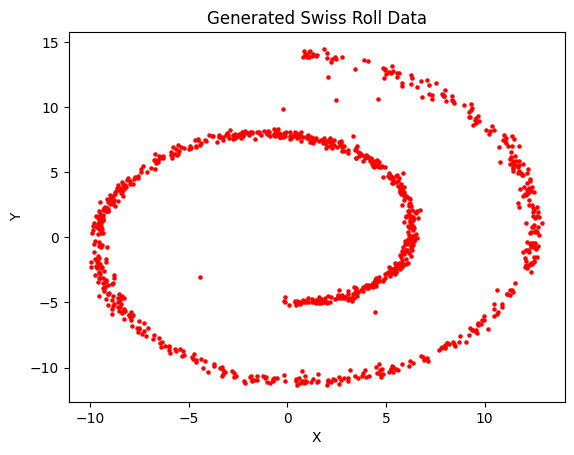

In [99]:
swiss_x = swiss_x.detach().numpy()
plt.scatter(swiss_x[:, 0], swiss_x[:, 1], s=5,  c='r')
plt.title("Generated Swiss Roll Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

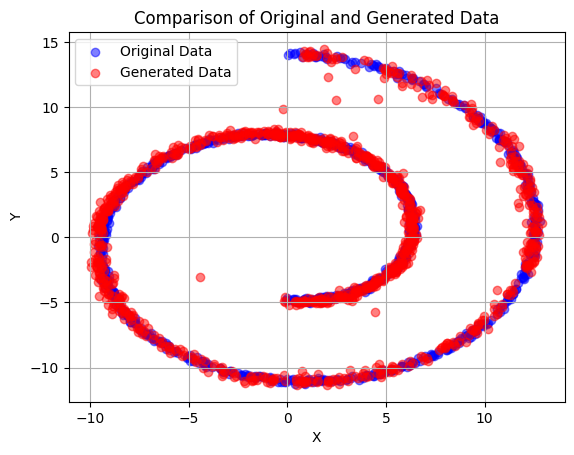

In [100]:
plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.5, label='Original Data')
plt.scatter(swiss_x[:, 0], swiss_x[:, 1], c='red', alpha=0.5, label='Generated Data')
plt.title('Comparison of Original and Generated Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
data_pca = pca.fit_transform(data)
swiss_x_pca = pca.transform(swiss_x)

In [105]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance
from sklearn.neighbors import KernelDensity


kde_real = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data)
kde_generated = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(swiss_x)

log_dens_real = kde_real.score_samples(data)
log_dens_generated = kde_generated.score_samples(swiss_x)

kl_divergence = entropy(np.exp(log_dens_real), np.exp(log_dens_generated))
print(f"KL Divergence: {kl_divergence}")


wasserstein_dist = wasserstein_distance(swiss_x_pca.flatten(),data_pca.flatten(),)
print(f"Wasserstein Distance: {wasserstein_dist}")


KL Divergence: 0.18775302235417668
Wasserstein Distance: 0.4044215360163943


In [102]:
from scipy.linalg import sqrtm

def calculate_fid(real_features, generated_features):
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    
    mu_generated = np.mean(generated_features, axis=0)
    sigma_generated = np.cov(generated_features, rowvar=False)
    
    diff = mu_real - mu_generated
    covmean = sqrtm(sigma_real.dot(sigma_generated))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_generated - 2 * covmean)
    return fid


fid_score = calculate_fid(data, swiss_x)
print(f"FID Score: {fid_score}")

FID Score: 0.5466242245808219
